In [1]:
from analysis_tools import*

# Specify the metrics to use
zeroshot_metrics = ['zeroshot-val-top1']
retrieval_metrics = ['image_to_text_R@{}', 'text_to_image_R@{}'] # Format paths 

# Specify the datasets to use
zeroshot_datasets = ['RSICD-CLS', 'UCM-CLS', 'WHU-RS19', 'RSSCN7', 'AID', 'RESISC45']
retrieval_datasets = ['RSICD', 'UCM', 'Sydney']

base_fontsize = 20

# Specify the paths of the (text!) files in which the results are stored 
validation_path = './results/eval.txt'
test_path = './results/test_eval.txt'

# Hyperparameter tuning results

In [2]:
df_grouped = prep_and_store_results(validation_path)

Number of evaluations: 53410
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,60.99,0.1,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,56.84,0.1,base,False,NaN,NaN,None,5,0.00005,64
2,RSICD,image_to_text_R@1,4.76,0.1,base,False,NaN,NaN,None,5,0.00005,64
3,RSICD,image_to_text_R@5,20.05,0.1,base,False,NaN,NaN,None,5,0.00005,64
4,RSICD,image_to_text_R@10,33.88,0.1,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
53405,Sydney,image_to_text_R@5,13.68,0.1,base,True,20.0,20.0,None,25,0.00005,32
53406,Sydney,image_to_text_R@10,19.52,0.1,base,True,20.0,20.0,None,25,0.00005,32
53407,Sydney,text_to_image_R@1,5.03,0.1,base,True,20.0,20.0,None,25,0.00005,32
53408,Sydney,text_to_image_R@5,12.47,0.1,base,True,20.0,20.0,None,25,0.00005,32


value  \
                                                                                                     mean   
dataset method ProbVLM ratio PL        metric            epochs bs  AL.epochs AL.iter lr                    
RSICD   base   False   0.1   None      image_to_text_R@1 5      64  5.0       20.0    0.000050   2.993333   
                                                                    10.0      20.0    0.000050   3.053333   
                                                                    20.0      20.0    0.000050   3.110000   
                                                                    NaN       NaN     0.000005   3.448889   
                                                                                      0.000010   4.120000   
...                                                                                                   ...   
UCM-CLS ours   False   0.1   soft.text zeroshot-val-top1 35     64  NaN       NaN     0.000050  65.557500   
                                                                                      0.000500   4.812500   
                                                                128 NaN       NaN     0.000005  59.908889   
                                                                                      0.000050  68.810000   
                                                                                      0.000500   4.808889   

                                                                                                          \
                                                                                                     std   
dataset method ProbVLM ratio PL        metric            epochs bs  AL.epochs AL.iter lr                   
RSICD   base   False   0.1   None      image_to_text_R@1 5      64  5.0       20.0    0.000050  0.501431   
                                                                    10.0      20.0    0.000050  0.780534   
                                                                    20.0      20.0    0.000050       NaN   
                                                                    NaN       NaN     0.000005  0.353357   
                                                                                      0.000010  0.000000   
...                                                                                                  ...   
UCM-CLS ours   False   0.1   soft.text zeroshot-val-top1 35     64  NaN       NaN     0.000050  6.541505   
                                                                                      0.000500  0.211877   
                                                                128 NaN       NaN     0.000005  3.114757   
                                                                                      0.000050  3.476025   
                                                                                      0.000500  0.187979   

                                                                                                      \
                                                                                               count   
dataset method ProbVLM ratio PL        metric            epochs bs  AL.epochs AL.iter lr               
RSICD   base   False   0.1   None      image_to_text_R@1 5      64  5.0       20.0    0.000050     3   
                                                                    10.0      20.0    0.000050     3   
                                                                    20.0      20.0    0.000050     1   
                                                                    NaN       NaN     0.000005     9   
                                                                                      0.000010     2   
...                                                                                              ...   
UCM-CLS ours   False   0.1   soft.text zeroshot-val-top1 35     64  NaN       NaN     0.000050     4   
                    

In [3]:
df_results = df_grouped.reset_index()
# We fill NaN values in the AL.epochs column to avoid issues with dropping rows with NaNs
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

dataset method ProbVLM ratio         PL             metric epochs   bs  \
                                                                               
2168    RSICD   ours   False   0.1  soft.text  image_to_text_R@1      5   64   
2198    RSICD   ours   False   0.1  soft.text  image_to_text_R@1     30   64   
1199    RSICD   ours   False   0.1  hard.text  image_to_text_R@1     35  128   
1412    RSICD   ours   False   0.1   ot.image  image_to_text_R@1      5   64   
1415    RSICD   ours   False   0.1   ot.image  image_to_text_R@1      5  128   
...       ...    ...     ...   ...        ...                ...    ...  ...   
7746  UCM-CLS   base   False   0.5       None  zeroshot-val-top1      5   64   
7751  UCM-CLS   base   False   0.7       None  zeroshot-val-top1     15   64   
7749  UCM-CLS   base   False   0.7       None  zeroshot-val-top1      5   64   
7748  UCM-CLS   base   False   0.5       None  zeroshot-val-top1     15   64   
7750  UCM-CLS   base   False   0.7       None  zeroshot-val-top1     10   64   

     AL.epochs AL.iter       lr    value                  \
                                    mean       std count   
2168       5.0     NaN  0.00050   0.0675  0.045000     4   
2198      30.0     NaN  0.00050   0.0675  0.045000     4   
1199      35.0     NaN  0.00050   0.0700  0.039686     9   
1412       5.0     NaN  0.00050   0.0700  0.060000     9   
1415       5.0     NaN  0.00050   0.0800  0.030000     9   
...        ...     ...      ...      ...       ...   ...   
7746       5.0     NaN  0.00005  77.7550  3.436680     4   
7751      15.0     NaN  0.00005  77.9725  3.209884     4   
7749       5.0     NaN  0.00005  78.1875  5.256433     4   
7748      15.0     NaN  0.00005  78.2875  3.939225     4   
7750      10.0     NaN  0.00005  78.3975  3.115032     4   

                                                                       
                                                    all    min    max  
2168                            [0.09, 0.09, 0.09, 0.0]   0.00   0.09  
2198                            [0.09, 0.0, 0.09, 0.09]   0.00   0.09  
1199  [0.09, 0.0, 0.09, 0.09, 0.09, 0.09, 0.0, 0.09,...   0.00   0.09  
1412  [0.09, 0.0, 0.09, 0.09, 0.18, 0.09, 0.0, 0.0, ...   0.00   0.18  
1415  [0.09, 0.09, 0.09, 0.09, 0.0, 0.09, 0.09, 0.09...   0.00   0.09  
...                                                 ...    ...    ...  
7746                        [81.2, 77.68, 79.06, 73.08]  73.08  81.20  
7751                        [76.07, 82.4, 75.21, 78.21]  75.21  82.40  
7749                       [78.21, 83.26, 70.94, 80.34]  70.94  83.26  
7748                        [84.19, 76.39, 76.5, 76.07]  76.07  84.19  
7750                       [73.93, 80.26, 78.63, 80.77]  73.93  80.77  

[8040 rows x 17 columns]

In [4]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_method(df_results)

#Loop over the methods to show the tuning results
for method in results_dict:
    print(method)
    df_method = results_dict[method].groupby(['metric', 'dataset'])
    full_display(df_method.tail(3))

baseline


dataset method ProbVLM ratio    PL              metric epochs   bs  \
                                                                             
89        RSICD   base   False   0.1  None   image_to_text_R@1     25   64   
101       RSICD   base   False   0.1  None   image_to_text_R@1     35   64   
95        RSICD   base   False   0.1  None   image_to_text_R@1     30   64   
2906     Sydney   base   False   0.1  None   image_to_text_R@1     30   64   
2909     Sydney   base   False   0.1  None   image_to_text_R@1     30  128   
2915     Sydney   base   False   0.1  None   image_to_text_R@1     35  128   
5330        UCM   base   False   0.1  None   image_to_text_R@1     35   64   
5321        UCM   base   False   0.1  None   image_to_text_R@1     25  128   
5324        UCM   base   False   0.1  None   image_to_text_R@1     30   64   
201       RSICD   base   False   0.1  None  image_to_text_R@10     30   64   
195       RSICD   base   False   0.1  None  image_to_text_R@10     25   64   
207       RSICD   base   False   0.1  None  image_to_text_R@10     35   64   
3015     Sydney   base   False   0.1  None  image_to_text_R@10     30  128   
3012     Sydney   base   False   0.1  None  image_to_text_R@10     30   64   
3018     Sydney   base   False   0.1  None  image_to_text_R@10     35   64   
5436        UCM   base   False   0.1  None  image_to_text_R@10     35   64   
5439        UCM   base   False   0.1  None  image_to_text_R@10     35  128   
5433        UCM   base   False   0.1  None  image_to_text_R@10     30  128   
301       RSICD   base   False   0.1  None   image_to_text_R@5     25   64   
307       RSICD   base   False   0.1  None   image_to_text_R@5     30   64   
313       RSICD   base   False   0.1  None   image_to_text_R@5     35   64   
3118     Sydney   base   False   0.1  None   image_to_text_R@5     30   64   
3121     Sydney   base   False   0.1  None   image_to_text_R@5     30  128   
3127     Sydney   base   False   0.1  None   image_to_text_R@5     35  128   
5545        UCM   base   False   0.1  None   image_to_text_R@5     35  128   
5542        UCM   base   False   0.1  None   image_to_text_R@5     35   64   
5539        UCM   base   False   0.1  None   image_to_text_R@5     30  128   
407       RSICD   base   False   0.1  None   text_to_image_R@1     25   64   
413       RSICD   base   False   0.1  None   text_to_image_R@1     30   64   
419       RSICD   base   False   0.1  None   text_to_image_R@1     35   64   
3221     Sydney   base   False   0.1  None   text_to_image_R@1     25  128   
3227     Sydney   base   False   0.1  None   text_to_image_R@1     30  128   
3233     Sydney   base   False   0.1  None   text_to_image_R@1     35  128   
5642        UCM   base   False   0.1  None   text_to_image_R@1     30   64   
5645        UCM   base   False   0.1  None   text_to_image_R@1     30  128   
5651        UCM   base   False   0.1  None   text_to_image_R@1     35  128   
513       RSICD   base   False   0.1  None  text_to_image_R@10     25   64   
525       RSICD   base   False   0.1  None  text_to_image_R@10     35   64   
519       RSICD   base   False   0.1  None  text_to_image_R@10     30   64   
3339     Sydney   base   False   0.1  None  text_to_image_R@10     35  128   
3336     Sydney   base   False   0.1  None  text_to_image_R@10     35   64   
3330     Sydney   base   False   0.1  None  text_to_image_R@10     30   64   
5757        UCM   base   False   0.1  None  text_to_image_R@10     35  128   
5748        UCM   base   False   0.1  None  text_to_image_R@10     30   64   
5754        UCM   base   False   0.1  None  text_to_image_R@10     35   64   
619       RSICD   base   False   0.1  None   text_to_image_R@5     25   64   
631       RSICD   base   False   0.1  None   text_to_image_R@5     35   64   
625       RSICD   base   False   0.1  None   text_to_image_R@5     30   64   
3439     Sydney   base   False   0.1  None   text_to_image_R@5     30  128   
3442     Sydney   base   False

s-clip


dataset method ProbVLM ratio        PL              metric epochs  \
                                                                            
1438      RSICD   ours   False   0.1  ot.image   image_to_text_R@1     25   
1444      RSICD   ours   False   0.1  ot.image   image_to_text_R@1     30   
1450      RSICD   ours   False   0.1  ot.image   image_to_text_R@1     35   
4237     Sydney   ours   False   0.1  ot.image   image_to_text_R@1     15   
4255     Sydney   ours   False   0.1  ot.image   image_to_text_R@1     30   
4261     Sydney   ours   False   0.1  ot.image   image_to_text_R@1     35   
6667        UCM   ours   False   0.1  ot.image   image_to_text_R@1     25   
6673        UCM   ours   False   0.1  ot.image   image_to_text_R@1     30   
6679        UCM   ours   False   0.1  ot.image   image_to_text_R@1     35   
1480      RSICD   ours   False   0.1  ot.image  image_to_text_R@10     25   
1492      RSICD   ours   False   0.1  ot.image  image_to_text_R@10     35   
1486      RSICD   ours   False   0.1  ot.image  image_to_text_R@10     30   
4291     Sydney   ours   False   0.1  ot.image  image_to_text_R@10     25   
4297     Sydney   ours   False   0.1  ot.image  image_to_text_R@10     30   
4303     Sydney   ours   False   0.1  ot.image  image_to_text_R@10     35   
6718        UCM   ours   False   0.1  ot.image  image_to_text_R@10     35   
6715        UCM   ours   False   0.1  ot.image  image_to_text_R@10     30   
6721        UCM   ours   False   0.1  ot.image  image_to_text_R@10     35   
1522      RSICD   ours   False   0.1  ot.image   image_to_text_R@5     25   
1528      RSICD   ours   False   0.1  ot.image   image_to_text_R@5     30   
1534      RSICD   ours   False   0.1  ot.image   image_to_text_R@5     35   
4336     Sydney   ours   False   0.1  ot.image   image_to_text_R@5     30   
4339     Sydney   ours   False   0.1  ot.image   image_to_text_R@5     30   
4345     Sydney   ours   False   0.1  ot.image   image_to_text_R@5     35   
6763        UCM   ours   False   0.1  ot.image   image_to_text_R@5     35   
6757        UCM   ours   False   0.1  ot.image   image_to_text_R@5     30   
6751        UCM   ours   False   0.1  ot.image   image_to_text_R@5     25   
1570      RSICD   ours   False   0.1  ot.image   text_to_image_R@1     30   
1576      RSICD   ours   False   0.1  ot.image   text_to_image_R@1     35   
1573      RSICD   ours   False   0.1  ot.image   text_to_image_R@1     35   
4387     Sydney   ours   False   0.1  ot.image   text_to_image_R@1     35   
4381     Sydney   ours   False   0.1  ot.image   text_to_image_R@1     30   
4375     Sydney   ours   False   0.1  ot.image   text_to_image_R@1     25   
6793        UCM   ours   False   0.1  ot.image   text_to_image_R@1     25   
6799        UCM   ours   False   0.1  ot.image   text_to_image_R@1     30   
6805        UCM   ours   False   0.1  ot.image   text_to_image_R@1     35   
1606      RSICD   ours   False   0.1  ot.image  text_to_image_R@10     25   
1612      RSICD   ours   False   0.1  ot.image  text_to_image_R@10     30   
1618      RSICD   ours   False   0.1  ot.image  text_to_image_R@10     35   
4417     Sydney   ours   False   0.1  ot.image  text_to_image_R@10     25   
4423     Sydney   ours   False   0.1  ot.image  text_to_image_R@10     30   
4429     Sydney   ours   False   0.1  ot.image  text_to_image_R@10     35   
6841        UCM   ours   False   0.1  ot.image  text_to_image_R@10     30   
6844        UCM   ours   False   0.1  ot.image  text_to_image_R@10     35   
6847        UCM   ours   False   0.1  ot.image  text_to_image_R@10     35   
1648      RSICD   ours   False   0.1  ot.image   text_to_image_R@5     25   
1660      RSICD   ours   False   0.1  ot.image   text_to_image_R@5     35   
1654      RSICD   ours   False   0.1  ot.image   text_to_image_R@5     30   
4459     Sydney   ours   False   0.1  ot.image   text_to_image_R@5     25   
4465     Sydney   ours   False   0.1  ot.image   text_to_image_R@5     30   
4471

soft-pl


dataset method ProbVLM ratio          PL              metric epochs  \
                                                                              
2197      RSICD   ours   False   0.1   soft.text   image_to_text_R@1     30   
1948      RSICD   ours   False   0.1  soft.image   image_to_text_R@1     30   
2203      RSICD   ours   False   0.1   soft.text   image_to_text_R@1     35   
4759     Sydney   ours   False   0.1  soft.image   image_to_text_R@1     30   
5014     Sydney   ours   False   0.1   soft.text   image_to_text_R@1     35   
4765     Sydney   ours   False   0.1  soft.image   image_to_text_R@1     35   
7429        UCM   ours   False   0.1   soft.text   image_to_text_R@1     30   
7432        UCM   ours   False   0.1   soft.text   image_to_text_R@1     35   
7435        UCM   ours   False   0.1   soft.text   image_to_text_R@1     35   
2248      RSICD   ours   False   0.1   soft.text  image_to_text_R@10     35   
2245      RSICD   ours   False   0.1   soft.text  image_to_text_R@10     35   
2239      RSICD   ours   False   0.1   soft.text  image_to_text_R@10     30   
5044     Sydney   ours   False   0.1   soft.text  image_to_text_R@10     25   
5053     Sydney   ours   False   0.1   soft.text  image_to_text_R@10     30   
5059     Sydney   ours   False   0.1   soft.text  image_to_text_R@10     35   
7213        UCM   ours   False   0.1  soft.image  image_to_text_R@10     25   
7474        UCM   ours   False   0.1   soft.text  image_to_text_R@10     35   
7468        UCM   ours   False   0.1   soft.text  image_to_text_R@10     30   
2290      RSICD   ours   False   0.1   soft.text   image_to_text_R@5     35   
2281      RSICD   ours   False   0.1   soft.text   image_to_text_R@5     30   
2287      RSICD   ours   False   0.1   soft.text   image_to_text_R@5     35   
4849     Sydney   ours   False   0.1  soft.image   image_to_text_R@5     35   
5095     Sydney   ours   False   0.1   soft.text   image_to_text_R@5     30   
5101     Sydney   ours   False   0.1   soft.text   image_to_text_R@5     35   
7513        UCM   ours   False   0.1   soft.text   image_to_text_R@5     30   
7510        UCM   ours   False   0.1   soft.text   image_to_text_R@5     30   
7516        UCM   ours   False   0.1   soft.text   image_to_text_R@5     35   
2332      RSICD   ours   False   0.1   soft.text   text_to_image_R@1     35   
2323      RSICD   ours   False   0.1   soft.text   text_to_image_R@1     30   
2326      RSICD   ours   False   0.1   soft.text   text_to_image_R@1     30   
5131     Sydney   ours   False   0.1   soft.text   text_to_image_R@1     25   
4885     Sydney   ours   False   0.1  soft.image   text_to_image_R@1     30   
5143     Sydney   ours   False   0.1   soft.text   text_to_image_R@1     35   
7297        UCM   ours   False   0.1  soft.image   text_to_image_R@1     25   
7558        UCM   ours   False   0.1   soft.text   text_to_image_R@1     35   
7309        UCM   ours   False   0.1  soft.image   text_to_image_R@1     35   
2374      RSICD   ours   False   0.1   soft.text  text_to_image_R@10     35   
2365      RSICD   ours   False   0.1   soft.text  text_to_image_R@10     30   
2371      RSICD   ours   False   0.1   soft.text  text_to_image_R@10     35   
5179     Sydney   ours   False   0.1   soft.text  text_to_image_R@10     30   
4933     Sydney   ours   False   0.1  soft.image  text_to_image_R@10     35   
5185     Sydney   ours   False   0.1   soft.text  text_to_image_R@10     35   
7588        UCM   ours   False   0.1   soft.text  text_to_image_R@10     25   
7594        UCM   ours   False   0.1   soft.text  text_to_image_R@10     30   
7600        UCM   ours   False   0.1   soft.text  text_to_image_R@10     35   
2410      RSICD   ours   False   0.1   soft.text   text_to_image_R@5     30   
2407      RSICD   ours   False   0.1   soft.text   text_to_image_R@5     30   
2413      RSICD   ours   False   0.1   soft.text   text_to_image_R@5     35   
5221     Sydney   ours   False   0.1   soft.text   text_to

hard-pl


dataset method ProbVLM ratio          PL              metric epochs  \
                                                                              
1183      RSICD   ours   False   0.1   hard.text   image_to_text_R@1     25   
1198      RSICD   ours   False   0.1   hard.text   image_to_text_R@1     35   
1195      RSICD   ours   False   0.1   hard.text   image_to_text_R@1     35   
3754     Sydney   ours   False   0.1  hard.image   image_to_text_R@1     35   
3748     Sydney   ours   False   0.1  hard.image   image_to_text_R@1     30   
3994     Sydney   ours   False   0.1   hard.text   image_to_text_R@1     25   
6166        UCM   ours   False   0.1  hard.image   image_to_text_R@1     30   
6421        UCM   ours   False   0.1   hard.text   image_to_text_R@1     30   
6427        UCM   ours   False   0.1   hard.text   image_to_text_R@1     35   
1240      RSICD   ours   False   0.1   hard.text  image_to_text_R@10     35   
1231      RSICD   ours   False   0.1   hard.text  image_to_text_R@10     30   
1237      RSICD   ours   False   0.1   hard.text  image_to_text_R@10     35   
4051     Sydney   ours   False   0.1   hard.text  image_to_text_R@10     35   
4042     Sydney   ours   False   0.1   hard.text  image_to_text_R@10     30   
4048     Sydney   ours   False   0.1   hard.text  image_to_text_R@10     35   
6208        UCM   ours   False   0.1  hard.image  image_to_text_R@10     30   
6466        UCM   ours   False   0.1   hard.text  image_to_text_R@10     35   
6460        UCM   ours   False   0.1   hard.text  image_to_text_R@10     30   
1279      RSICD   ours   False   0.1   hard.text   image_to_text_R@5     35   
1267      RSICD   ours   False   0.1   hard.text   image_to_text_R@5     25   
1273      RSICD   ours   False   0.1   hard.text   image_to_text_R@5     30   
4084     Sydney   ours   False   0.1   hard.text   image_to_text_R@5     30   
4093     Sydney   ours   False   0.1   hard.text   image_to_text_R@5     35   
4078     Sydney   ours   False   0.1   hard.text   image_to_text_R@5     25   
6511        UCM   ours   False   0.1   hard.text   image_to_text_R@5     35   
6256        UCM   ours   False   0.1  hard.image   image_to_text_R@5     35   
6505        UCM   ours   False   0.1   hard.text   image_to_text_R@5     30   
1309      RSICD   ours   False   0.1   hard.text   text_to_image_R@1     25   
1315      RSICD   ours   False   0.1   hard.text   text_to_image_R@1     30   
1321      RSICD   ours   False   0.1   hard.text   text_to_image_R@1     35   
4123     Sydney   ours   False   0.1   hard.text   text_to_image_R@1     25   
4135     Sydney   ours   False   0.1   hard.text   text_to_image_R@1     35   
4129     Sydney   ours   False   0.1   hard.text   text_to_image_R@1     30   
6544        UCM   ours   False   0.1   hard.text   text_to_image_R@1     30   
6553        UCM   ours   False   0.1   hard.text   text_to_image_R@1     35   
6298        UCM   ours   False   0.1  hard.image   text_to_image_R@1     35   
1366      RSICD   ours   False   0.1   hard.text  text_to_image_R@10     35   
1357      RSICD   ours   False   0.1   hard.text  text_to_image_R@10     30   
1363      RSICD   ours   False   0.1   hard.text  text_to_image_R@10     35   
4168     Sydney   ours   False   0.1   hard.text  text_to_image_R@10     30   
4171     Sydney   ours   False   0.1   hard.text  text_to_image_R@10     30   
4177     Sydney   ours   False   0.1   hard.text  text_to_image_R@10     35   
6586        UCM   ours   False   0.1   hard.text  text_to_image_R@10     30   
6580        UCM   ours   False   0.1   hard.text  text_to_image_R@10     25   
6592        UCM   ours   False   0.1   hard.text  text_to_image_R@10     35   
1408      RSICD   ours   False   0.1   hard.text   text_to_image_R@5     35   
1399      RSICD   ours   False   0.1   hard.text   text_to_image_R@5     30   
1405      RSICD   ours   False   0.1   hard.text   text_to_image_R@5     35   
4204     Sydney   ours   False   0.1   hard.text   text_to

basic-al


dataset method ProbVLM ratio    PL              metric epochs  bs  \
                                                                            
59        RSICD   base   False   0.1  None   image_to_text_R@1     20  64   
61        RSICD   base   False   0.1  None   image_to_text_R@1     20  64   
62        RSICD   base   False   0.1  None   image_to_text_R@1     20  64   
2892     Sydney   base   False   0.1  None   image_to_text_R@1     25  64   
2894     Sydney   base   False   0.1  None   image_to_text_R@1     25  64   
2878     Sydney   base   False   0.1  None   image_to_text_R@1     20  64   
5295        UCM   base   False   0.1  None   image_to_text_R@1     20  64   
5288        UCM   base   False   0.1  None   image_to_text_R@1     20  64   
5294        UCM   base   False   0.1  None   image_to_text_R@1     20  64   
119       RSICD   base   False   0.1  None  image_to_text_R@10     10  64   
165       RSICD   base   False   0.1  None  image_to_text_R@10     20  64   
167       RSICD   base   False   0.1  None  image_to_text_R@10     20  64   
2978     Sydney   base   False   0.1  None  image_to_text_R@10     20  64   
3000     Sydney   base   False   0.1  None  image_to_text_R@10     25  64   
2984     Sydney   base   False   0.1  None  image_to_text_R@10     20  64   
5350        UCM   base   False   0.1  None  image_to_text_R@10     10  64   
5377        UCM   base   False   0.1  None  image_to_text_R@10     15  64   
5394        UCM   base   False   0.1  None  image_to_text_R@10     20  64   
277       RSICD   base   False   0.1  None   image_to_text_R@5     20  64   
274       RSICD   base   False   0.1  None   image_to_text_R@5     20  64   
273       RSICD   base   False   0.1  None   image_to_text_R@5     20  64   
3091     Sydney   base   False   0.1  None   image_to_text_R@5     20  64   
3106     Sydney   base   False   0.1  None   image_to_text_R@5     25  64   
3090     Sydney   base   False   0.1  None   image_to_text_R@5     20  64   
5456        UCM   base   False   0.1  None   image_to_text_R@5     10  64   
5483        UCM   base   False   0.1  None   image_to_text_R@5     15  64   
5500        UCM   base   False   0.1  None   image_to_text_R@5     20  64   
398       RSICD   base   False   0.1  None   text_to_image_R@1     25  64   
401       RSICD   base   False   0.1  None   text_to_image_R@1     25  64   
386       RSICD   base   False   0.1  None   text_to_image_R@1     20  64   
3190     Sydney   base   False   0.1  None   text_to_image_R@1     20  64   
3196     Sydney   base   False   0.1  None   text_to_image_R@1     20  64   
3212     Sydney   base   False   0.1  None   text_to_image_R@1     25  64   
5615        UCM   base   False   0.1  None   text_to_image_R@1     20  64   
5613        UCM   base   False   0.1  None   text_to_image_R@1     20  64   
5630        UCM   base   False   0.1  None   text_to_image_R@1     25  64   
486       RSICD   base   False   0.1  None  text_to_image_R@10     20  64   
483       RSICD   base   False   0.1  None  text_to_image_R@10     20  64   
485       RSICD   base   False   0.1  None  text_to_image_R@10     20  64   
3316     Sydney   base   False   0.1  None  text_to_image_R@10     25  64   
3301     Sydney   base   False   0.1  None  text_to_image_R@10     20  64   
3302     Sydney   base   False   0.1  None  text_to_image_R@10     20  64   
5736        UCM   base   False   0.1  None  text_to_image_R@10     25  64   
5689        UCM   base   False   0.1  None  text_to_image_R@10     15  64   
5695        UCM   base   False   0.1  None  text_to_image_R@10     15  64   
589       RSICD   base   False   0.1  None   text_to_image_R@5     20  64   
567       RSICD   base   False   0.1  None   text_to_image_R@5     15  64   
591       RSICD   base   False   0.1  None   text_to_image_R@5     20  64   
3422     Sydney   base   False   0.1  None   text_to_image_R@5     25  64   
3405     Sydney   base   False   0.1  None   text_to_image_R@5     20  64   
3408

probvlm


dataset method ProbVLM ratio    PL              metric epochs  bs  \
                                                                            
719       RSICD   base    True   0.1  None   image_to_text_R@1     25  32   
705       RSICD   base    True   0.1  None   image_to_text_R@1     10  32   
720       RSICD   base    True   0.1  None   image_to_text_R@1     25  32   
3522     Sydney   base    True   0.1  None   image_to_text_R@1     15  32   
3529     Sydney   base    True   0.1  None   image_to_text_R@1     25  32   
3536     Sydney   base    True   0.1  None   image_to_text_R@1     25  32   
5954        UCM   base    True   0.1  None   image_to_text_R@1     25  32   
5949        UCM   base    True   0.1  None   image_to_text_R@1     25  32   
5952        UCM   base    True   0.1  None   image_to_text_R@1     25  32   
747       RSICD   base    True   0.1  None  image_to_text_R@10     15  32   
744       RSICD   base    True   0.1  None  image_to_text_R@10     15  32   
756       RSICD   base    True   0.1  None  image_to_text_R@10     25  32   
3562     Sydney   base    True   0.1  None  image_to_text_R@10     15  32   
3570     Sydney   base    True   0.1  None  image_to_text_R@10     25  32   
3572     Sydney   base    True   0.1  None  image_to_text_R@10     25  32   
5986        UCM   base    True   0.1  None  image_to_text_R@10     25  32   
5965        UCM   base    True   0.1  None  image_to_text_R@10     10  32   
5964        UCM   base    True   0.1  None  image_to_text_R@10     10  32   
790       RSICD   base    True   0.1  None   image_to_text_R@5     25  32   
782       RSICD   base    True   0.1  None   image_to_text_R@5     15  32   
792       RSICD   base    True   0.1  None   image_to_text_R@5     25  32   
3607     Sydney   base    True   0.1  None   image_to_text_R@5     25  32   
3608     Sydney   base    True   0.1  None   image_to_text_R@5     25  32   
3606     Sydney   base    True   0.1  None   image_to_text_R@5     25  32   
6026        UCM   base    True   0.1  None   image_to_text_R@5     25  32   
6022        UCM   base    True   0.1  None   image_to_text_R@5     25  32   
6024        UCM   base    True   0.1  None   image_to_text_R@5     25  32   
821       RSICD   base    True   0.1  None   text_to_image_R@1     15  32   
816       RSICD   base    True   0.1  None   text_to_image_R@1     15  32   
828       RSICD   base    True   0.1  None   text_to_image_R@1     25  32   
3640     Sydney   base    True   0.1  None   text_to_image_R@1     25  32   
3644     Sydney   base    True   0.1  None   text_to_image_R@1     25  32   
3642     Sydney   base    True   0.1  None   text_to_image_R@1     25  32   
6051        UCM   base    True   0.1  None   text_to_image_R@1     15  32   
6055        UCM   base    True   0.1  None   text_to_image_R@1     25  32   
6054        UCM   base    True   0.1  None   text_to_image_R@1     25  32   
867       RSICD   base    True   0.1  None  text_to_image_R@10     25  32   
843       RSICD   base    True   0.1  None  text_to_image_R@10     10  32   
864       RSICD   base    True   0.1  None  text_to_image_R@10     25  32   
3675     Sydney   base    True   0.1  None  text_to_image_R@10     25  32   
3680     Sydney   base    True   0.1  None  text_to_image_R@10     25  32   
3678     Sydney   base    True   0.1  None  text_to_image_R@10     25  32   
6090        UCM   base    True   0.1  None  text_to_image_R@10     25  32   
6094        UCM   base    True   0.1  None  text_to_image_R@10     25  32   
6096        UCM   base    True   0.1  None  text_to_image_R@10     25  32   
899       RSICD   base    True   0.1  None   text_to_image_R@5     25  32   
893       RSICD   base    True   0.1  None   text_to_image_R@5     15  32   
900       RSICD   base    True   0.1  None   text_to_image_R@5     25  32   
3709     Sydney   base    True   0.1  None   text_to_image_R@5     25  32   
3716     Sydney   base    True   0.1  None   text_to_image_R@5     25  32   
3714

# Test split evaluation results

In [5]:
df_grouped = prep_and_store_results(test_path)

Number of evaluations: 75376
Column names: ['AL.epochs', 'AL.iter', 'PL', 'ProbVLM', 'bs', 'dataset', 'epochs', 'lr', 'method', 'metric', 'ratio', 'value']


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
75371,Sydney,image_to_text_R@5,23.94,0.80,base,False,40.0,10.0,None,20,0.00005,64
75372,Sydney,image_to_text_R@10,36.22,0.80,base,False,40.0,10.0,None,20,0.00005,64
75373,Sydney,text_to_image_R@1,9.66,0.80,base,False,40.0,10.0,None,20,0.00005,64
75374,Sydney,text_to_image_R@5,27.77,0.80,base,False,40.0,10.0,None,20,0.00005,64


,dataset,metric,value,ratio,method,ProbVLM,AL.iter,AL.epochs,PL,epochs,lr,bs
0,RSICD-CLS,zeroshot-val-top1,48.58,0.05,base,False,NaN,NaN,None,5,0.00005,64
1,UCM-CLS,zeroshot-val-top1,46.19,0.05,base,False,NaN,NaN,None,5,0.00005,64
2,WHU-RS19,zeroshot-val-top1,71.94,0.05,base,False,NaN,NaN,None,5,0.00005,64
3,RSSCN7,zeroshot-val-top1,58.14,0.05,base,False,NaN,NaN,None,5,0.00005,64
4,AID,zeroshot-val-top1,52.05,0.05,base,False,NaN,NaN,None,5,0.00005,64
...,...,...,...,...,...,...,...,...,...,...,...,...
75371,Sydney,image_to_text_R@5,23.94,0.80,base,False,40.0,10.0,None,20,0.00005,64
75372,Sydney,image_to_text_R@10,36.22,0.80,base,False,40.0,10.0,None,20,0.00005,64
75373,Sydney,text_to_image_R@1,9.66,0.80,base,False,40.0,10.0,None,20,0.00005,64
75374,Sydney,text_to_image_R@5,27.77,0.80,base,False,40.0,10.0,None,20,0.00005,64


value  \
                                                                                                 mean   
dataset  method ProbVLM ratio PL        metric            epochs bs AL.epochs AL.iter lr                
AID      base   False   0.00  None      zeroshot-val-top1 0      64 NaN       NaN     0.00005  52.820   
                        0.05  None      zeroshot-val-top1 1      64 NaN       NaN     0.00005  29.820   
                                                          2      64 NaN       NaN     0.00005  29.890   
                                                          3      64 NaN       NaN     0.00005  35.940   
                                                          4      64 NaN       NaN     0.00005  43.200   
...                                                                                               ...   
WHU-RS19 ours   False   0.80  soft.text zeroshot-val-top1 26     64 NaN       NaN     0.00005  96.874   
                                                          27     64 NaN       NaN     0.00005  96.498   
                                                          28     64 NaN       NaN     0.00005  96.954   
                                                          29     64 NaN       NaN     0.00005  96.576   
                                                          30     64 NaN       NaN     0.00005  96.734   

                                                                                                         \
                                                                                                    std   
dataset  method ProbVLM ratio PL        metric            epochs bs AL.epochs AL.iter lr                  
AID      base   False   0.00  None      zeroshot-val-top1 0      64 NaN       NaN     0.00005  0.000000   
                        0.05  None      zeroshot-val-top1 1      64 NaN       NaN     0.00005       NaN   
                                                          2      64 NaN       NaN     0.00005       NaN   
                                                          3      64 NaN       NaN     0.00005       NaN   
                                                          4      64 NaN       NaN     0.00005       NaN   
...                                                                                                 ...   
WHU-RS19 ours   False   0.80  soft.text zeroshot-val-top1 26     64 NaN       NaN     0.00005  0.601190   
                                                          27     64 NaN       NaN     0.00005  0.653391   
                                                          28     64 NaN       NaN     0.00005  0.774358   
                                                          29     64 NaN       NaN     0.00005  0.679066   
                                                          30     64 NaN       NaN     0.00005  0.760809   

                                                                                                     \
                                                                                              count   
dataset  method ProbVLM ratio PL        metric            epochs bs AL.epochs AL.iter lr              
AID      base   False   0.00  None      zeroshot-val-top1 0      64 NaN       NaN     0.00005     2   
                        0.05  None      zeroshot-val-top1 1      64 NaN       NaN     0.00005     1   
                                                          2      64 NaN       NaN     0.00005     1   
                                                          3      64 NaN       NaN     0.00005     1   
                                                          4      64 NaN       NaN     0.00005     1   
...                                                                                             ...   
WHU-RS19 ours   False   0.80  soft.text zeroshot-val-top1 26     64 NaN       NaN     0.00005     5   
                                                          27     64 NaN       NaN     0.00005   

In [6]:
df_results = df_grouped.reset_index()
df_results['AL.epochs'] = df_results['AL.epochs'].fillna(df_results['epochs'])
df_results = df_results.sort_values(['metric', 'dataset', ('value', 'mean')])
display(df_results)

dataset method ProbVLM ratio         PL             metric epochs  \
                                                                            
1704      RSICD   ours   False  0.05  hard.text  image_to_text_R@1      1   
2334      RSICD   ours   False  0.10   ot.image  image_to_text_R@1      1   
1854      RSICD   ours   False  0.05   ot.image  image_to_text_R@1      1   
2004      RSICD   ours   False  0.05  soft.text  image_to_text_R@1      1   
1855      RSICD   ours   False  0.05   ot.image  image_to_text_R@1      2   
...         ...    ...     ...   ...        ...                ...    ...   
12257  WHU-RS19   ours   False  0.80  hard.text  zeroshot-val-top1     22   
12273  WHU-RS19   ours   False  0.80   ot.image  zeroshot-val-top1     13   
12258  WHU-RS19   ours   False  0.80  hard.text  zeroshot-val-top1     23   
12280  WHU-RS19   ours   False  0.80   ot.image  zeroshot-val-top1     20   
12279  WHU-RS19   ours   False  0.80   ot.image  zeroshot-val-top1     19   

        bs AL.epochs AL.iter       lr   value                  \
                                         mean       std count   
1704    64       1.0     NaN  0.00005   0.694  0.049295     5   
2334   128       1.0     NaN  0.00005   0.912  0.067231     5   
1854   128       1.0     NaN  0.00005   1.010  0.000000     5   
2004    64       1.0     NaN  0.00005   1.040  0.238747     5   
1855   128       2.0     NaN  0.00005   1.300  0.318512     5   
...    ...       ...     ...      ...     ...       ...   ...   
12257   64      22.0     NaN  0.00005  97.172  0.979398     5   
12273  128      13.0     NaN  0.00005  97.272  0.308577     5   
12258   64      23.0     NaN  0.00005  97.352  1.024119     5   
12280  128      20.0     NaN  0.00005  97.372  0.308577     5   
12279  128      19.0     NaN  0.00005  97.532  0.621627     5   

                                                          
                                       all    min    max  
1704        [0.73, 0.73, 0.64, 0.73, 0.64]   0.64   0.73  
2334        [0.91, 1.01, 0.82, 0.91, 0.91]   0.82   1.01  
1854        [1.01, 1.01, 1.01, 1.01, 1.01]   1.01   1.01  
2004        [0.91, 1.46, 1.01, 0.91, 0.91]   0.91   1.46  
1855           [1.1, 1.83, 1.1, 1.1, 1.37]   1.10   1.83  
...                                    ...    ...    ...  
12257  [97.61, 95.42, 97.61, 97.61, 97.61]  95.42  97.61  
12273  [97.41, 96.72, 97.41, 97.41, 97.41]  96.72  97.41  
12258  [97.81, 95.52, 97.81, 97.81, 97.81]  95.52  97.81  
12280  [97.51, 96.82, 97.51, 97.51, 97.51]  96.82  97.51  
12279  [97.81, 96.42, 97.81, 97.81, 97.81]  96.42  97.81  

[12316 rows x 17 columns]

In [7]:
# Get the results, split per model (e.g. get results of baseline, s-clip, etc.)
results_dict = get_results_per_method(df_results, False)

,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
3,baseline vs basic-al,RSICD-CLS,zeroshot-val-top1,487.0,0.013,True
7,s-clip vs basic-al,RSICD-CLS,zeroshot-val-top1,388.0,0.006,True
8,s-clip vs probvlm,RSICD-CLS,zeroshot-val-top1,421.0,0.036,True
10,soft-pl vs basic-al,RSICD-CLS,zeroshot-val-top1,370.5,0.018,True
12,hard-pl vs basic-al,RSICD-CLS,zeroshot-val-top1,383.0,0.008,True


,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
10,soft-pl vs basic-al,UCM-CLS,zeroshot-val-top1,366.0,0.022,True
11,soft-pl vs probvlm,UCM-CLS,zeroshot-val-top1,443.5,0.011,True


,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
3,baseline vs basic-al,WHU-RS19,zeroshot-val-top1,466.5,0.034,True
4,baseline vs probvlm,WHU-RS19,zeroshot-val-top1,565.5,0.017,True
7,s-clip vs basic-al,WHU-RS19,zeroshot-val-top1,430.0,0.0,True
8,s-clip vs probvlm,WHU-RS19,zeroshot-val-top1,462.0,0.004,True
10,soft-pl vs basic-al,WHU-RS19,zeroshot-val-top1,429.0,0.0,True
11,soft-pl vs probvlm,WHU-RS19,zeroshot-val-top1,468.0,0.003,True
12,hard-pl vs basic-al,WHU-RS19,zeroshot-val-top1,410.0,0.001,True
13,hard-pl vs probvlm,WHU-RS19,zeroshot-val-top1,477.0,0.001,True


,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
4,baseline vs probvlm,RSSCN7,zeroshot-val-top1,560.0,0.021,True
10,soft-pl vs basic-al,RSSCN7,zeroshot-val-top1,362.5,0.028,True
11,soft-pl vs probvlm,RSSCN7,zeroshot-val-top1,478.5,0.001,True


,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
3,baseline vs basic-al,AID,zeroshot-val-top1,479.0,0.009,True
7,s-clip vs basic-al,AID,zeroshot-val-top1,390.0,0.005,True
8,s-clip vs probvlm,AID,zeroshot-val-top1,434.0,0.019,True
10,soft-pl vs basic-al,AID,zeroshot-val-top1,395.0,0.004,True
11,soft-pl vs probvlm,AID,zeroshot-val-top1,432.0,0.021,True
12,hard-pl vs basic-al,AID,zeroshot-val-top1,401.5,0.002,True
13,hard-pl vs probvlm,AID,zeroshot-val-top1,417.0,0.043,True


,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
3,baseline vs basic-al,RESISC45,zeroshot-val-top1,494.0,0.004,True
4,baseline vs probvlm,RESISC45,zeroshot-val-top1,603.0,0.001,True
7,s-clip vs basic-al,RESISC45,zeroshot-val-top1,401.0,0.002,True
8,s-clip vs probvlm,RESISC45,zeroshot-val-top1,502.0,0.0,True
10,soft-pl vs basic-al,RESISC45,zeroshot-val-top1,414.0,0.001,True
11,soft-pl vs probvlm,RESISC45,zeroshot-val-top1,500.0,0.0,True
12,hard-pl vs basic-al,RESISC45,zeroshot-val-top1,366.0,0.023,True
13,hard-pl vs probvlm,RESISC45,zeroshot-val-top1,495.0,0.0,True


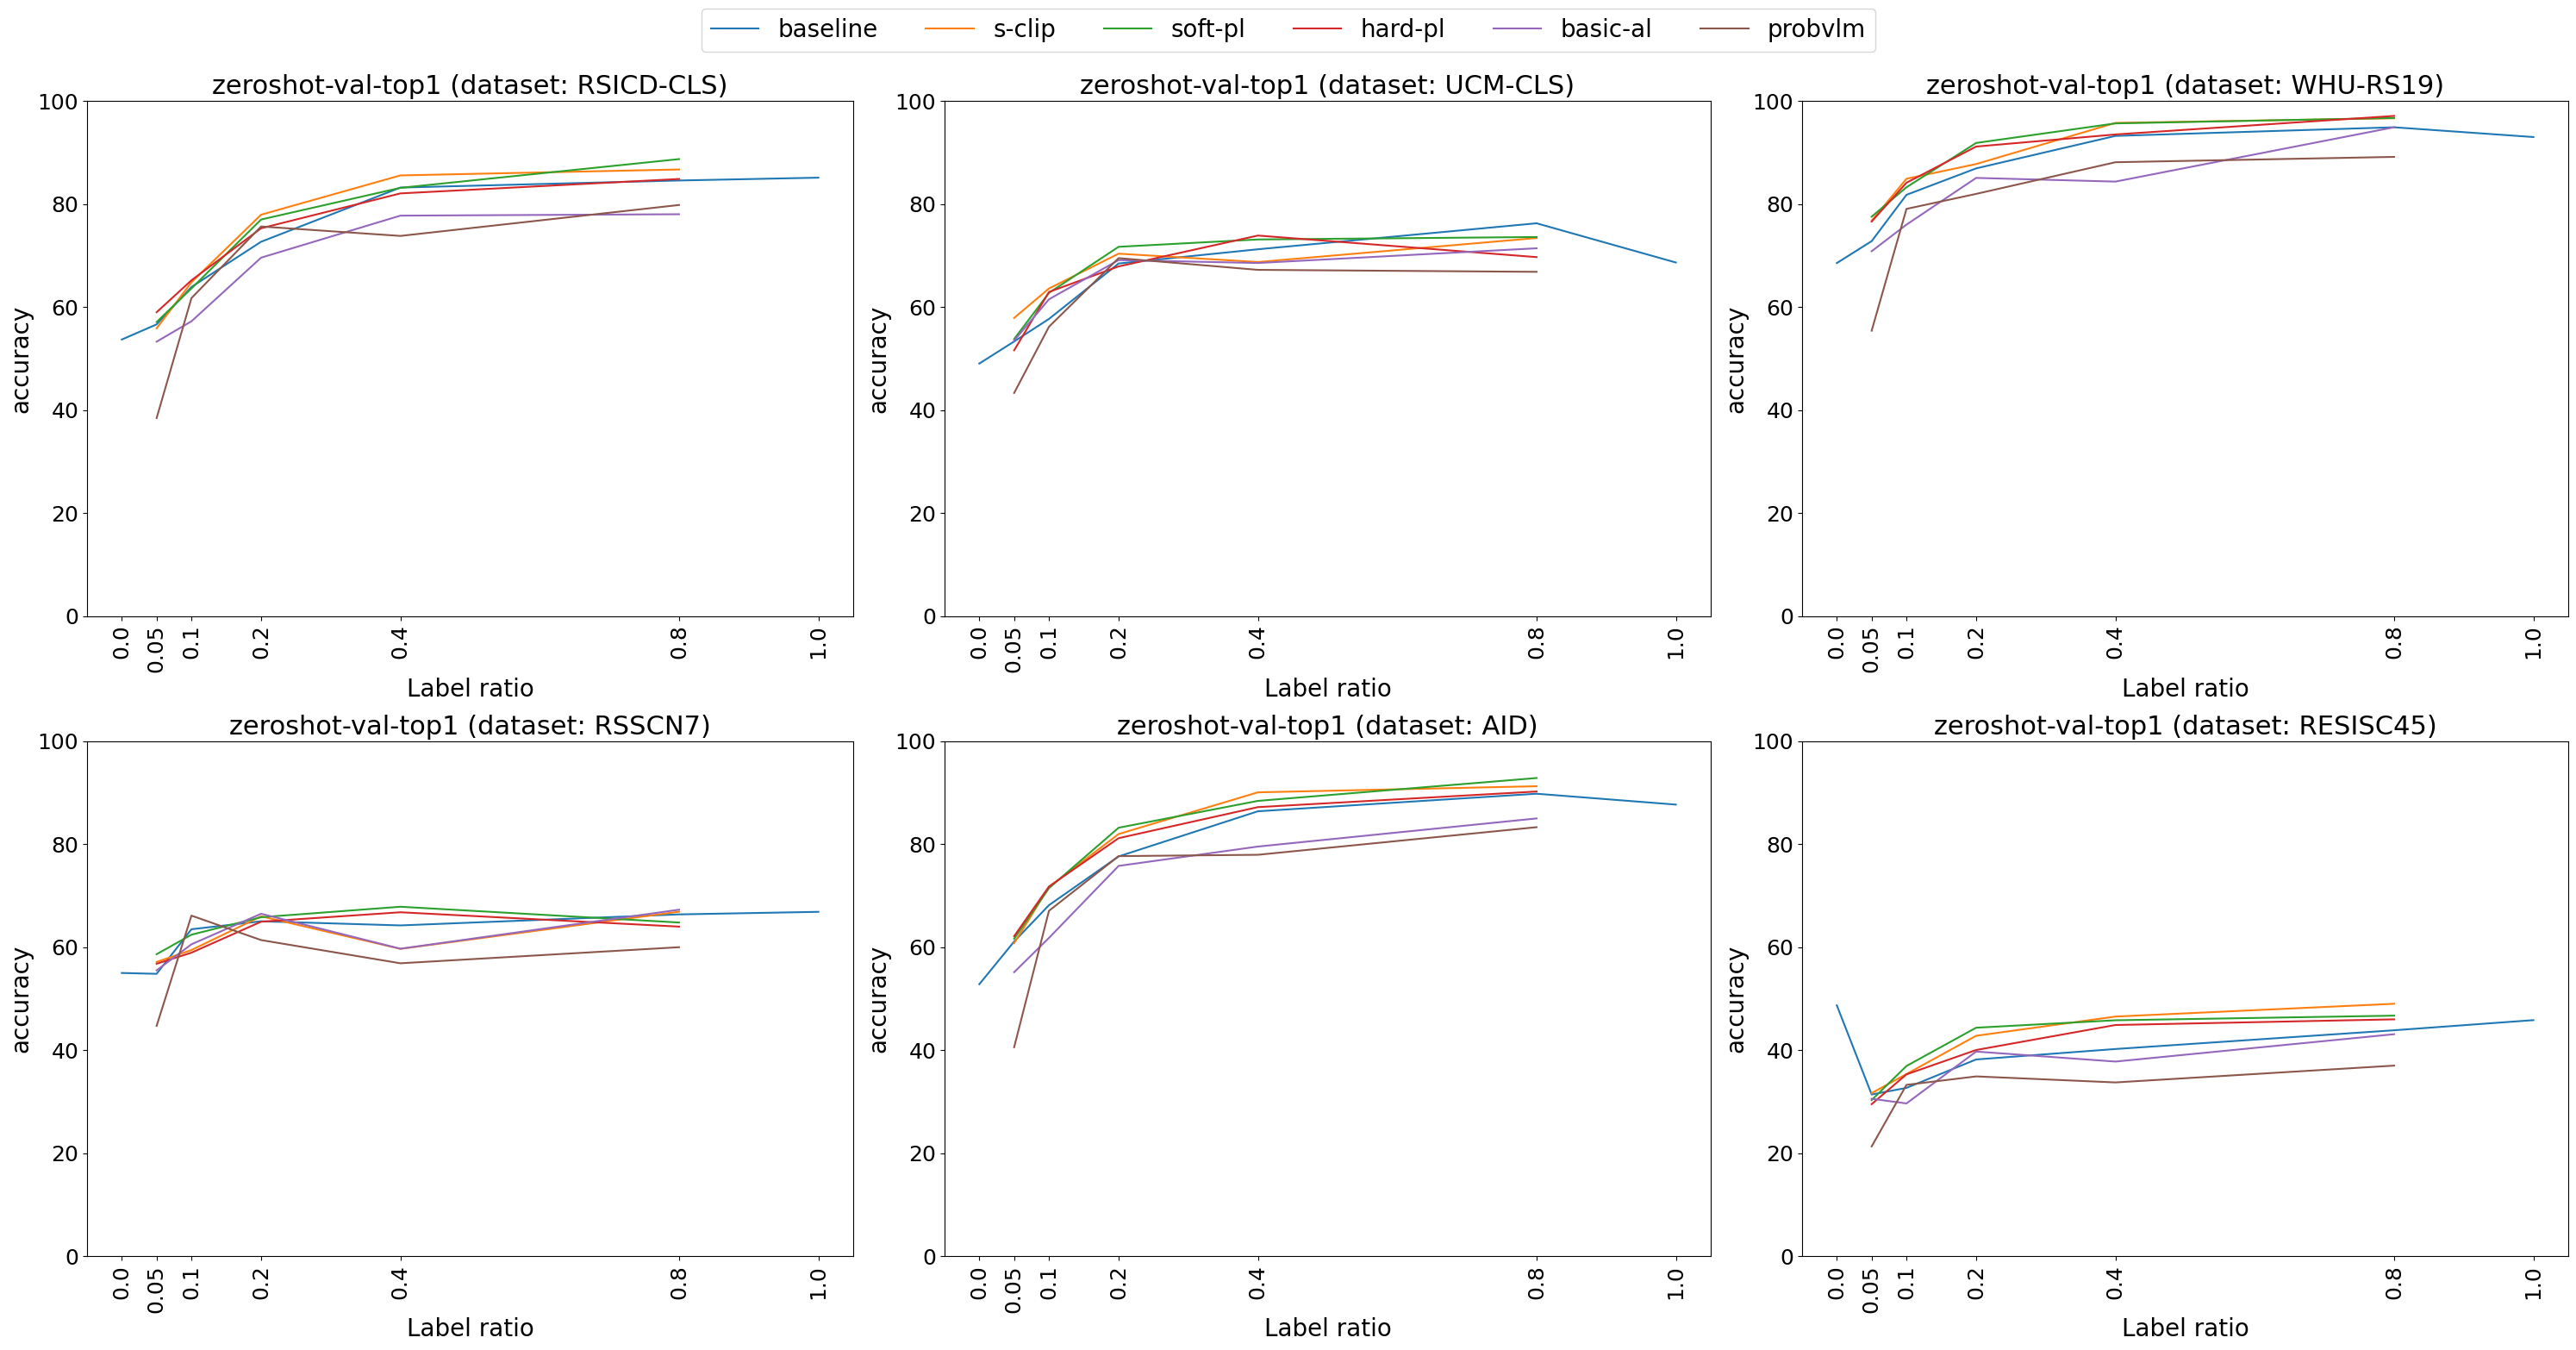

In [8]:
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize = (30, 15))

row, col = 0, 0
for metric in zeroshot_metrics:
    for dataset in zeroshot_datasets:
#         print(dataset, metric)
        label = row == 0 and col == 0 # only assign a legend label for the first subplot (prevents duplicates)
        plot_model_comparison(results_dict, metric, dataset, ax = axes[row][col], label = label, 
                              base_fontsize = base_fontsize, confidence_band_type = '')
        col += 1
        if col == cols:
            col = 0
            row += 1
fig.legend(loc='upper center', ncol=6, fancybox=True, bbox_to_anchor=(0.5, 1.05), fontsize = base_fontsize)
plt.tight_layout()
plt.show()

,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
3,baseline vs basic-al,RSICD,image_to_text_R@1,478.0,0.01,True
4,baseline vs probvlm,RSICD,image_to_text_R@1,559.5,0.01,True
12,hard-pl vs basic-al,RSICD,image_to_text_R@1,361.5,0.029,True
13,hard-pl vs probvlm,RSICD,image_to_text_R@1,433.0,0.019,True


,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
3,baseline vs basic-al,RSICD,text_to_image_R@1,484.0,0.007,True
4,baseline vs probvlm,RSICD,text_to_image_R@1,566.5,0.008,True
10,soft-pl vs basic-al,RSICD,text_to_image_R@1,361.5,0.029,True
12,hard-pl vs basic-al,RSICD,text_to_image_R@1,375.5,0.013,True
13,hard-pl vs probvlm,RSICD,text_to_image_R@1,432.0,0.021,True


,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
3,baseline vs basic-al,UCM,image_to_text_R@1,450.0,0.038,True
4,baseline vs probvlm,UCM,image_to_text_R@1,585.5,0.003,True
7,s-clip vs basic-al,UCM,image_to_text_R@1,392.5,0.004,True
8,s-clip vs probvlm,UCM,image_to_text_R@1,491.5,0.001,True
10,soft-pl vs basic-al,UCM,image_to_text_R@1,355.5,0.04,True
11,soft-pl vs probvlm,UCM,image_to_text_R@1,463.5,0.003,True
13,hard-pl vs probvlm,UCM,image_to_text_R@1,447.5,0.009,True


,Comparing,dataset,metric,Mann-Whitney-U,p-val,p significant?
10,soft-pl vs basic-al,UCM,text_to_image_R@1,363.0,0.027,True
11,soft-pl vs probvlm,UCM,text_to_image_R@1,456.0,0.005,True


IndexError: index 2 is out of bounds for axis 0 with size 2

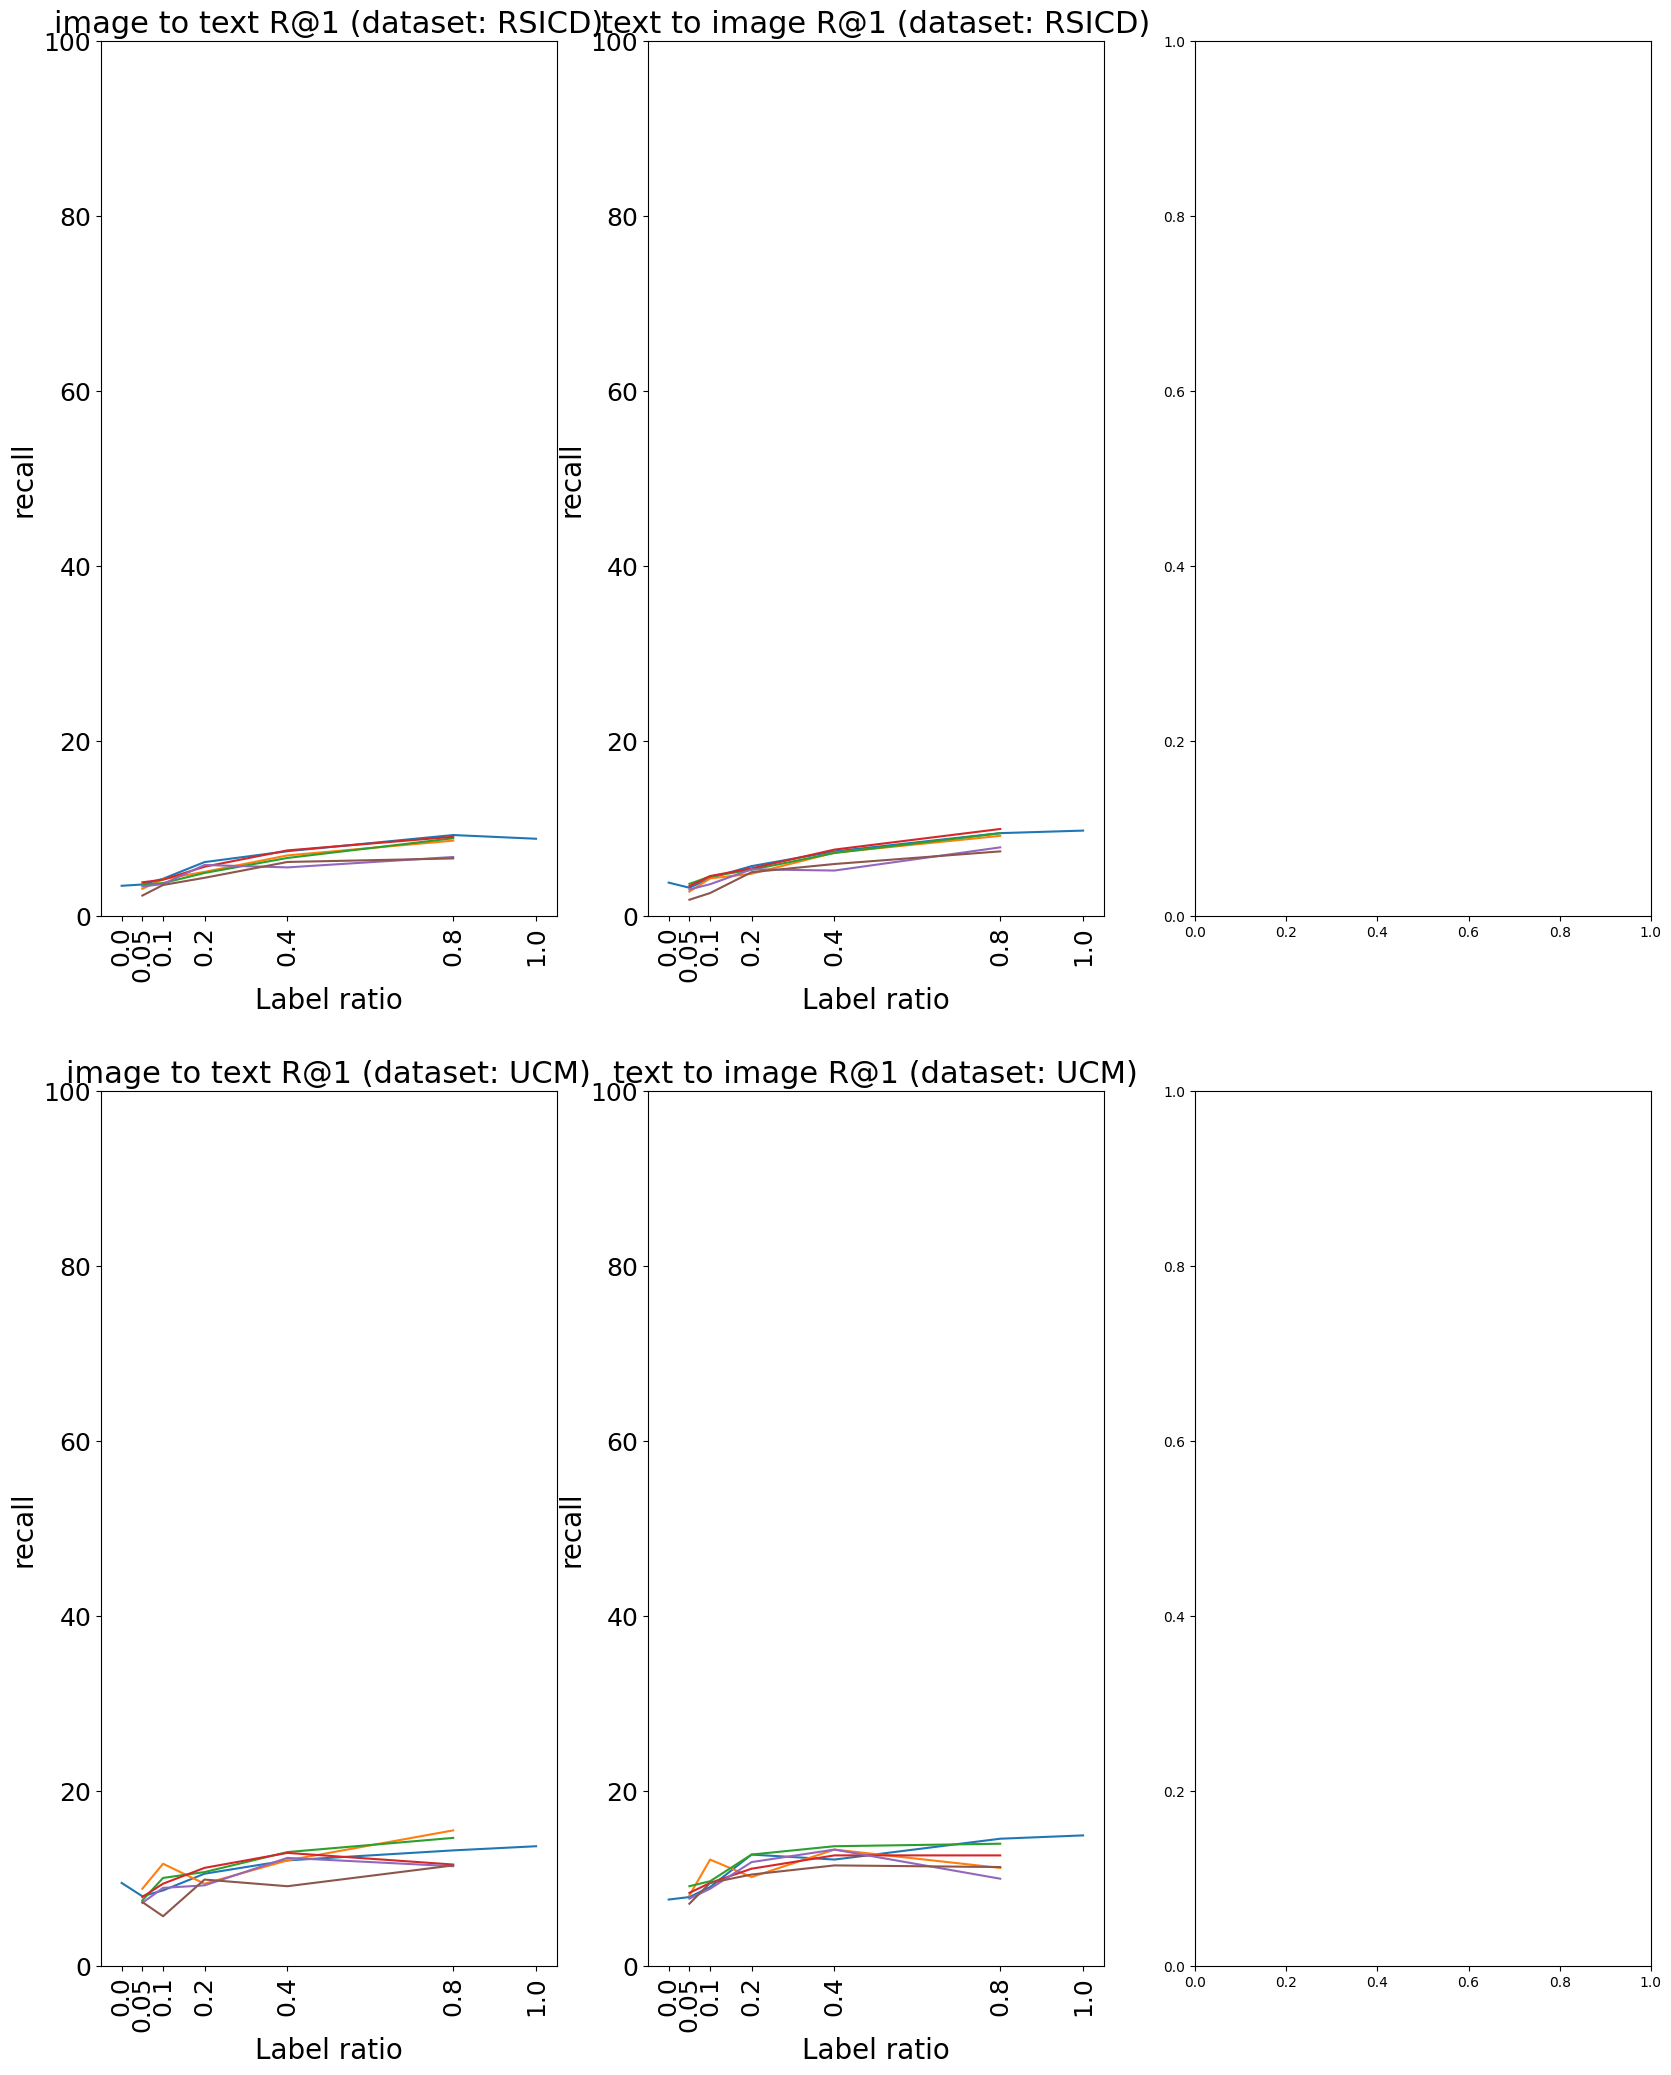

In [9]:
plot_recall_model_comparison(results_dict, retrieval_metrics, retrieval_datasets, base_fontsize = base_fontsize, k = 1, 
                            confidence_band_type = '')

In [ ]:
plot_recall_model_comparison(results_dict, retrieval_metrics, retrieval_datasets, base_fontsize = base_fontsize, k = 5,
                            confidence_band_type = '')

In [ ]:
plot_recall_model_comparison(results_dict, retrieval_metrics, retrieval_datasets, base_fontsize = base_fontsize, k = 10,
                            confidence_band_type = '')